# Assignment 3

## Install dependencies

In [17]:
%pip install numpy matplotlib pandas seaborn scikit-learn pennylane

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Imports

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding
import matplotlib.pyplot as plt
import seaborn as sns
from pennylane import draw
from joblib import Parallel, delayed
import time

## Data Preprocessing

In [19]:
# Load Dataset
dataset = pd.read_csv('soil_fertility.csv')
print("Dataset shape:", dataset.shape)
display(dataset.head())

Dataset shape: (880, 13)


,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Output
0,138,8.6,560,7.46,0.62,0.70,5.9,0.24,0.31,0.77,8.71,0.11,0
1,213,7.5,338,7.62,0.75,1.06,25.4,0.30,0.86,1.54,2.89,2.29,0
2,163,9.6,718,7.59,0.51,1.11,14.3,0.30,0.86,1.57,2.70,2.03,0
3,157,6.8,475,7.64,0.58,0.94,26.0,0.34,0.54,1.53,2.65,1.82,0
4,270,9.9,444,7.63,0.40,0.86,11.8,0.25,0.76,1.69,2.43,2.26,1


In [20]:
le = LabelEncoder()
dataset['Output'] = le.fit_transform(dataset['Output'])
display(dataset.head())

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Output
0,138,8.6,560,7.46,0.62,0.70,5.9,0.24,0.31,0.77,8.71,0.11,0
1,213,7.5,338,7.62,0.75,1.06,25.4,0.30,0.86,1.54,2.89,2.29,0
2,163,9.6,718,7.59,0.51,1.11,14.3,0.30,0.86,1.57,2.70,2.03,0
3,157,6.8,475,7.64,0.58,0.94,26.0,0.34,0.54,1.53,2.65,1.82,0
4,270,9.9,444,7.63,0.40,0.86,11.8,0.25,0.76,1.69,2.43,2.26,1


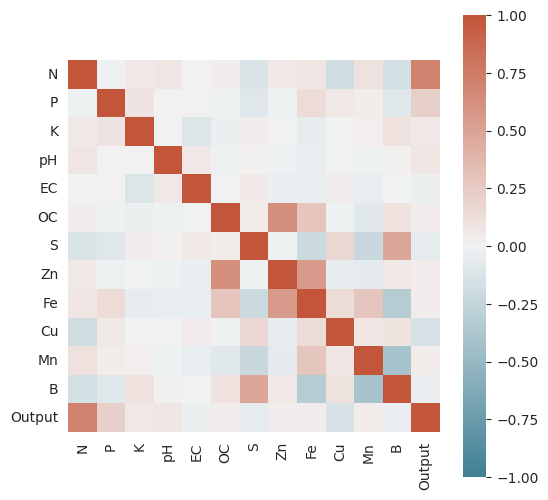

In [21]:
# Visualize Correlation Heatmap
plt.figure(figsize=(6, 6))
corr = dataset.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True), vmin=-1.0, vmax=1.0, square=True)
plt.show()

In [22]:
# Feature Selection
labels = dataset[['Output']]
features = dataset.drop(['Output', 'EC', 'OC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B'], axis=1)

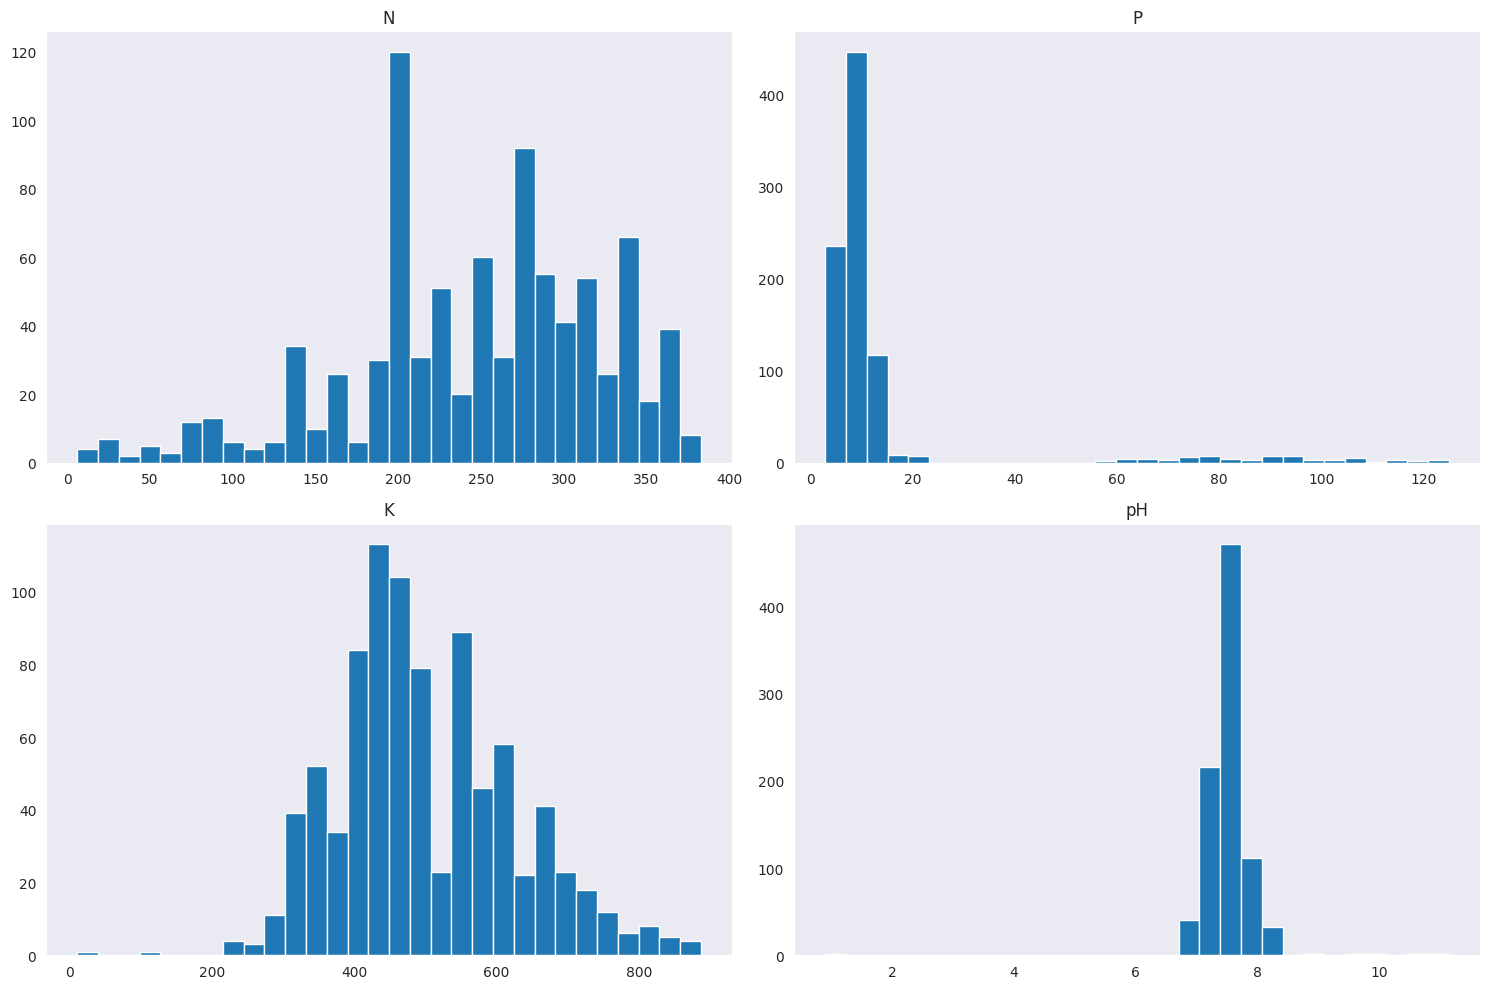

In [23]:
# Plot histograms for each feature
features.hist(bins=30, figsize=(15, 10), grid=False)
plt.tight_layout()
plt.show()

In [24]:
# Standard Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [25]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

## Classic SVM Model

In [26]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
pred = svc_clf.predict(X_test)
print(f"SVC Accuracy: {accuracy_score(y_test, pred):.2f}")
print(confusion_matrix(y_test, pred))

SVC Accuracy: 0.84
[[69  9  0]
 [ 9 79  0]
 [ 0 10  0]]


/home/24700746/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Quantum SVM

### Quantum Kernel

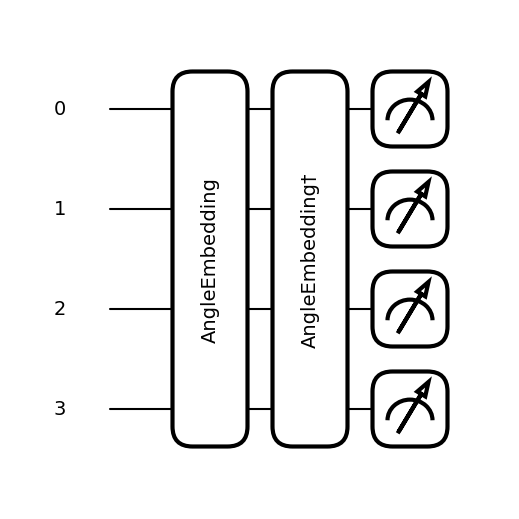

In [27]:
n_qubits = len(X_train[0])

dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B):
    start_time = time.time()
    kernel_values = np.array([[kernel(a, b) for b in B] for a in A])
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Kernel matrix computation took {elapsed_time:.2f} seconds.")

    return kernel_values

# Draw the circuit
fig, ax = qml.draw_mpl(kernel, decimals=2, wire_order=range(n_qubits), show_all_wires=True)(X_train[0], X_train[1])
plt.show()


### Train

In [28]:
precomputed_kernel = kernel_matrix(X_train, X_train)
svm = SVC(kernel='precomputed').fit(precomputed_kernel, y_train)

Kernel matrix computation took 1391.82 seconds.


/home/24700746/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Test

In [29]:
kernel_matrix_test = kernel_matrix(X_test, X_train)
predictions = svm.predict(kernel_matrix_test)
print(y_train.shape)
print(y_test.shape)
model_acc = accuracy_score(y_test, predictions)
print(f"Quantum SVM Accuracy: {model_acc:.2f}")
print(confusion_matrix(y_test, predictions))


Kernel matrix computation took 342.19 seconds.
(704, 1)
(176, 1)
Quantum SVM Accuracy: 0.84
[[68 10  0]
 [ 8 80  0]
 [ 1  9  0]]


## Quantum SVM in parallel (optimised)

### Quantum Kernel

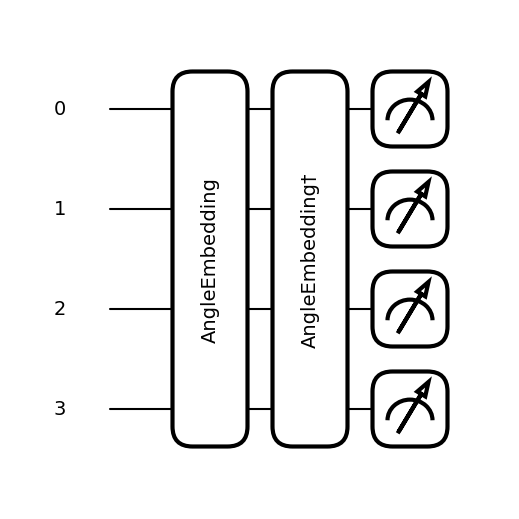

In [30]:
n_qubits = len(X_train[0])
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector_matrix[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector_matrix, wires=range(n_qubits)))

# Helper function to compute the kernel for each pair (a, b)
def kernel_for_pair(a, b):
    return kernel(a, b)

# Parallel Kernel Matrix Computation
def kernel_matrix(A, B):
    start_time = time.time()
    kernel_values = Parallel(n_jobs=-1, backend='loky')(
        delayed(kernel_for_pair)(a, b) for a in A for b in B
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Kernel matrix computation took {elapsed_time:.2f} seconds.")
    return np.array(kernel_values).reshape(len(A), len(B))

# Draw the circuit
fig, ax = qml.draw_mpl(kernel, decimals=2, wire_order=range(n_qubits), show_all_wires=True)(X_train[0], X_train[1])
plt.show()

### Training

In [31]:
# Train Quantum SVM using the precomputed kernel
precomputed_kernel_train = kernel_matrix(X_train, X_train)
svm_q = SVC(kernel='precomputed').fit(precomputed_kernel_train, y_train)

Kernel matrix computation took 415.25 seconds.


/home/24700746/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Testing

In [32]:
# Test Quantum SVM and Evaluate Accuracy
kernel_matrix_test = kernel_matrix(X_test, X_train)
predictions_q = svm_q.predict(kernel_matrix_test)
quantum_accuracy = accuracy_score(y_test, predictions_q)
print(f"Quantum SVM Accuracy: {quantum_accuracy:.2f}")

Kernel matrix computation took 101.61 seconds.
Quantum SVM Accuracy: 0.84
